#Import Modules



In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

#Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#Import train400 Dataset

In [ ]:
images = []
for i in range(9):
  image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/00{}.png".format(i+1))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  img = np.divide(input_arr, 255.0)
  images.append(img)

for i in range(10, 99):
  image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/0{}.png".format(i))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  img = np.divide(input_arr, 255.0)
  images.append(img)

for i in range(100, 400):
  image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/{}.png".format(i))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  img = np.divide(input_arr, 255.0)
  images.append(img)

In [ ]:
images = np.array(images)
print(images.shape)

(398, 180, 180, 3)


In [ ]:
# base_url = "/content/drive/MyDrive/datas/"
# folders = ["train400"]

In [ ]:
# import subprocess
# images = []
# for folder in folders:
#   output = subprocess.check_output("ls " + base_url + folder, shell=True)
#   print(type(output))
#   files_list = output.decode('utf-8').split('\n')
#   files_list.pop()

#   for image in files_list:
#     image_real = tf.keras.preprocessing.image.load_img(base_url + folder + "/" +image)
#     image_real = image_real.resize((300,300))
#     input_arr = tf.keras.preprocessing.image.img_to_array(image_real)
#     #  input_arr = input_arr.reshape((180,180,3))
#     img = np.divide(input_arr, 255.0)
#     images.append(img)

In [ ]:
# images = np.array(images)
# print(images.shape)

#ADD NOISE TO IMAGE

In [ ]:
tf.convert_to_tensor(img, dtype=None, dtype_hint=None, name=None)

import numpy as np
import os
import cv2
def noisy(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy




In [ ]:
image_noisy = []
for img in images:
  image_noisy.append(noisy(img))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(398, 180, 180, 3) (398, 180, 180, 3)


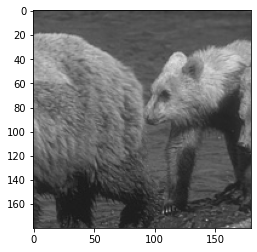

In [ ]:
image_noisy = np.array(image_noisy)
image_noisy.shape
plt.imshow(images[0].reshape(180,180,3))
print(type(images), type(image_noisy))
print(images.shape, image_noisy.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


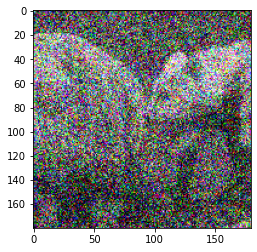

In [ ]:
plt.imshow(image_noisy[0])

#CREATING TRAINING AND VALIDATION DATASET

In [ ]:

train_images = images[0:320]
train_images_noisy = image_noisy[0:320]

val_images = images[321:398]
val_images_noisy = image_noisy[321:398]

print(train_images.shape, train_images_noisy.shape, val_images.shape, val_images_noisy.shape)

(320, 180, 180, 3) (320, 180, 180, 3) (77, 180, 180, 3) (77, 180, 180, 3)


#MODEL ARCHITECTURE

In [ ]:
input = layers.Input(shape=(180, 180, 3))

In [ ]:
# Encoder
def feature_extraction(input):
  # upper model
  x1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
  x2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x1)

  # lower model
  y1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(input)
  y2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(y1)

  # concat upper and lower model in feature extraction
  concatenated = tf.keras.layers.Concatenate(axis=-1)([x1, x2, y1, y2])

  return concatenated

In [ ]:
# Start of feature integration
def feature_integration(concatenated):
  conc_conv1 = layers.Conv2D(32, (1, 1), activation="sigmoid", padding="same")(concatenated)

  x3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(conc_conv1)
  x4 = layers.Conv2D(32, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x3)

  # x4  = layers.Dropout(0.2)(x4)

  y3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(conc_conv1)
  y4 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(y3)

  # y4  = layers.Dropout(0.2)(y4)

  concatenated2 = tf.keras.layers.Concatenate(axis=-1)([x3, x4, y3, y4])

  print(concatenated2.shape)

  conc_conv2 = layers.Conv2D(32, (1, 1), activation="sigmoid", padding="same")(concatenated2)

  concatenated3 = tf.keras.layers.Concatenate(axis=-1)([conc_conv1, conc_conv2])

  print(concatenated3.shape)

  return concatenated3

In [ ]:
# reconstruction
def reconstruction(concatenated3):
  x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(concatenated3)
  x = layers.Conv2DTranspose(32, (3, 3), activation="relu",  padding="same", dilation_rate=(2,2))(x)
  out = layers.Conv2D(3, (1, 1), activation="sigmoid", padding="same")(x)
  return out

In [ ]:
#making the ddfn model
model = feature_extraction(input)
for _ in range(3):
  model = feature_integration(model)
out = reconstruction(model)

(None, 180, 180, 128)
(None, 180, 180, 64)
(None, 180, 180, 128)
(None, 180, 180, 64)
(None, 180, 180, 128)
(None, 180, 180, 64)


In [ ]:
# running the model
autoencoder = Model(input, out)
opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 180, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 180, 180, 32  896         ['input_1[0][0]']                
                                )                                                             

#FITTING DATA

In [ ]:
import math

def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [ ]:
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks_list = [loss_history, lrate]

In [ ]:
history = autoencoder.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=32,validation_data=(val_images_noisy, val_images))

Epoch 1/100
10/10 [==============================] - 45s 3s/step - loss: 0.6977 - accuracy: 0.2982 - val_loss: 0.6793 - val_accuracy: 0.9779
Epoch 2/100
10/10 [==============================] - 24s 2s/step - loss: 0.6867 - accuracy: 0.3997 - val_loss: 0.6773 - val_accuracy: 0.9780
Epoch 3/100
10/10 [==============================] - 24s 2s/step - loss: 0.6860 - accuracy: 0.4244 - val_loss: 0.6799 - val_accuracy: 0.9782
Epoch 4/100
10/10 [==============================] - 24s 2s/step - loss: 0.6853 - accuracy: 0.4358 - val_loss: 0.6776 - val_accuracy: 0.9694
Epoch 5/100
10/10 [==============================] - 24s 2s/step - loss: 0.6830 - accuracy: 0.3640 - val_loss: 0.6698 - val_accuracy: 0.5405
Epoch 6/100
10/10 [==============================] - 24s 2s/step - loss: 0.6679 - accuracy: 0.4282 - val_loss: 0.6306 - val_accuracy: 0.3742
Epoch 7/100
10/10 [==============================] - 24s 2s/step - loss: 0.6274 - accuracy: 0.1871 - val_loss: 0.5985 - val_accuracy: 0.0792
Epoch 8/100
1

# Sharpen Image

#CREATING TEST DATASET

<class 'numpy.ndarray'>


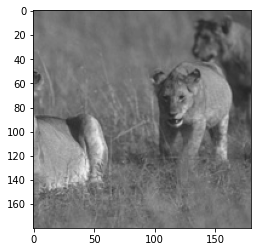

In [ ]:
test_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/007.png")
# test_image = test_image.resize((300,300))
input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
# input_arr = np.array([input_arr])  # Convert single image to a batch.
# predictions = model.predict(input_arr)
print(type(input_arr))
# input_arr = input_arr.reshape(3,180,180)
test_image = np.divide(input_arr, 255.0)

plt.imshow(test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


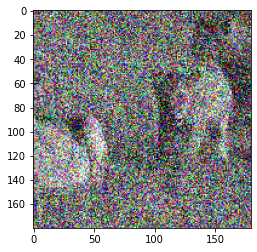

In [ ]:
test_image_noisy = noisy(test_image)
plt.imshow(test_image_noisy)

#PREDICTING MODEL

In [ ]:
reco = autoencoder.predict(test_image_noisy[None])[0]

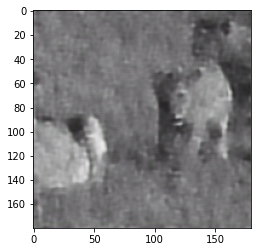

In [ ]:
plt.imshow(reco)

#PLOTTING GRAPH



In [ ]:
def plotting_graph(history,parameter):
  Y = []
  Z = []
  if parameter is "Loss":
    Y = np.array(history.history['loss'])
    Z = np.array(history.history['val_loss'])
  else:
    Y = np.array(history.history['accuracy'])
    Z = np.array(history.history['val_accuracy'])

  plt.plot(Y, color='r', label='training '+parameter)
  plt.plot(Z, color='g', label='validation '+parameter)
  plt.xlabel("Epochs")
  plt.ylabel(parameter)
  plt.title("{} vs Epoch".format(parameter))

  plt.legend()
  plt.show()

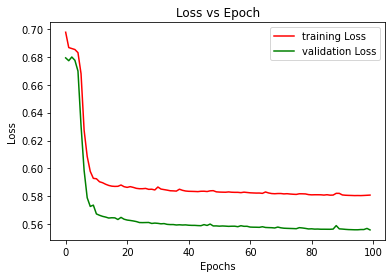

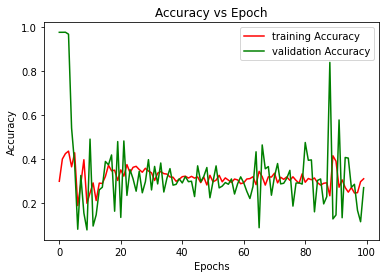

In [ ]:
plotting_graph(history,"Loss")
plotting_graph(history,"Accuracy")

In [73]:
import pickle
layer_1 = pickle.load(open('1_layer_history_', 'rb'))
layer_2 = pickle.load(open('2_layer_history', 'rb'))
layer_3 = pickle.load(open('3_layer_history', 'rb'))
layer_4 = pickle.load(open('4_layer_history', 'rb'))
layer_5 = pickle.load(open('5_layer_history', 'rb'))



In [74]:
print(layer_1)

{'loss': [0.0408075675368309, 0.007905167527496815, 0.0046168128028512, 0.004076207987964153, 0.0034326394088566303, 0.0031359123531728983, 0.003287927946075797, 0.0028341251891106367, 0.002535554114729166, 0.002393157687038183, 0.002339401748031378, 0.0022838227450847626, 0.0022067406680434942, 0.002126541221514344, 0.0021850767079740763, 0.0020649656653404236, 0.0020047298166900873, 0.001939538517035544, 0.0019418856827542186, 0.0018823558930307627, 0.0018501251470297575, 0.0018212230643257499, 0.0018596366280689836, 0.0017664659535512328, 0.001746860332787037, 0.0017454084008932114, 0.0020796963945031166, 0.0017649497603997588, 0.001701459288597107, 0.0016787907807156444, 0.0017077826196327806, 0.0016455240547657013, 0.001637590117752552, 0.0016403156332671642, 0.0016200930112972856, 0.001595832989551127, 0.0016652119811624289, 0.0015960640739649534, 0.001582795986905694, 0.0016243314603343606, 0.0015862801810726523, 0.001556606381200254, 0.0015443273587152362, 0.0016358012799173594

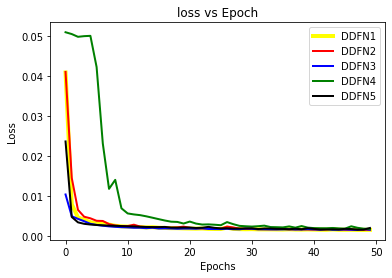

In [80]:
# print(layer_2.history["val_loss"])
import numpy as np
import matplotlib.pyplot as plt
Y1 = np.array(layer_1['loss'])
Y2 = np.array(layer_2.history['loss'])
Y3 = np.array(layer_3.history['loss'])
Y4 = np.array(layer_4.history['loss'])
Y5 = np.array(layer_5.history['loss'])

plt.plot(Y1, color='yellow', label='DDFN1', linewidth=4)
plt.plot(Y2, color='r', label='DDFN2', linewidth=2)
plt.plot(Y3, color='b', label='DDFN3', linewidth=2)
plt.plot(Y4, color='g', label='DDFN4', linewidth=2)
plt.plot(Y5, color='black', label='DDFN5', linewidth=2)


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("{} vs Epoch".format("loss"))

plt.legend()
plt.show()


No handles with labels found to put in legend.


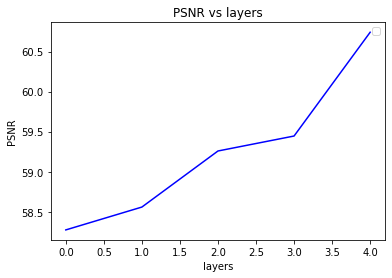

In [83]:
Y = [58.273306384785116, 58.558653936325824, 59.258417426258944, 59.44526150825719, 60.740528845663405]
plt.plot(Y, color='b')
plt.ylabel("PSNR")
plt.xlabel("layers")
plt.title("PSNR vs layers".format("loss"))

plt.legend()
plt.show()
